<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

Welcome to detectron2! This is the official colab tutorial of detectron2. Here, we will go through some basics usage of detectron2, including the following:
* Run inference on images or videos, with an existing detectron2 model
* Train a detectron2 model on a new dataset

You can make a copy of this tutorial by "File -> Open in playground mode" and play with it yourself. __DO NOT__ request access to this tutorial.


# Install detectron2

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Jul 17 19:37:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    43W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

torch:  1.9 ; cuda:  cu111


In [ ]:
# install correct version of pytorch
# pytorch must be compatible with GPU, Detectron2 and not crash colab

# work with GPU A100-SXM4-40GB & Tesla V100-SXM2-16GB
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 torchtext==0.10.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████                   | 834.1 MB 1.2 MB/s eta 0:16:50tcmalloc: large alloc 1147494400 bytes == 0x39e94000 @  0x7fa984b7e615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |████████████████▌               | 1055.7 MB 1.2 MB/s eta 0:13:59tcmalloc: large alloc 1434370048 bytes == 0x7e4ea000 @  0x7fa984b7e615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |█████

In [ ]:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/index.html
     |████████████████████████████████| 6.9 MB 456 kB/s 
     |████████████████████████████████| 50 kB 3.2 MB/s 
     |████████████████████████████████| 130 kB 9.8 MB/s 
     |████████████████████████████████| 79 kB 9.0 MB/s 
     |████████████████████████████████| 151 kB 69.5 MB/s 
     |████████████████████████████████| 843 kB 83.3 MB/s 
     |████████████████████████████████| 596 kB 85.6 MB/s 
     |████████████████████████████████| 117 kB 88.5 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20220512-py3-none-any.whl size=61288 sha256=f479bd24de323d480b4fa0963c18d83fcad7577c041776dafcb993396a303245
  Stored in directory: /root/.cache/pip/wheels/68/20/f9/a11a0dd63f4c13678b2a5ec488e48078756505c7777b75b29e
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.

In [ ]:
!pip install --upgrade mxnet-cu101 gluoncv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 360.0 MB 14 kB/s 
     |████████████████████████████████| 1.3 MB 69.8 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [ ]:
# Some basic setup:

# import some common libraries
import os, json, cv2, random, re, math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xml.etree.ElementTree as ET
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
import detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

# Setup detectron2 logger
from detectron2.utils.logger import setup_logger
setup_logger()

from gluoncv.utils import download, viz
import gluoncv as gcv

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.9.1` and `torch==1.9.0+cu111` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


In [ ]:
import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

fs = 20

# !wget https://github.com/angusforbes/tagriver/raw/master/data/fonts/Century.TTF
# fm.fontManager.ttflist += fm.createFontList(['Century.TTF'])
# mpl.rc('font', family='Century', size=18)

!wget https://github.com/trishume/OpenTuringCompiler/raw/master/stdlib-sfml/fonts/Times%20New%20Roman.ttf
fm.fontManager.ttflist += fm.createFontList(['Times New Roman.ttf'])
mpl.rc('font', family='Times New Roman', size=fs)

# !wget https://github.com/CartoDB/cartodb/raw/master/app/assets/fonts/helvetica.ttf
# fm.fontManager.ttflist += fm.createFontList(['helvetica.ttf'])
# mpl.rc('font', family='helvetica', size=fs)

--2022-07-17 20:16:12--  https://github.com/trishume/OpenTuringCompiler/raw/master/stdlib-sfml/fonts/Times%20New%20Roman.ttf
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/trishume/OpenTuringCompiler/master/stdlib-sfml/fonts/Times%20New%20Roman.ttf [following]
--2022-07-17 20:16:12--  https://raw.githubusercontent.com/trishume/OpenTuringCompiler/master/stdlib-sfml/fonts/Times%20New%20Roman.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 834452 (815K) [application/octet-stream]
Saving to: ‘Times New Roman.ttf’

Times New Roman.ttf 100%[===================>] 814.89K  --.-KB/s    in 0.04s   



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  if sys.path[0] == '':


# Train on a custom dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

We use the RGB fluorescence images of CAF model sample slides under 20X obj which only have one class: CAFs.
We'll train a CAF detection model from an existing model pre-trained on COCO/Pascal VOC dataset, available in [detectron2's model zoo](https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md).

Note that COCO dataset does not have the "CAF" category. We'll be able to recognize this new class in a few minutes.

## Prepare the dataset

In [ ]:
from google.colab import files, drive   

# mount the google drive to my Colab session
drive.mount('/content/gdrive')
# use the google drive in my Colab session
print(os.listdir('/content/gdrive/My Drive/'))
# files.download("data/training_and_test_accuracies.png")

Mounted at /content/gdrive
['Colab Notebooks', 'Dataset', 'Shared_with_me', 'GitHub_AI4Embryo', 'Shared_files', 'FPM-A experiment', 'Images']


In [ ]:
root_path = '/content/gdrive/My Drive/Dataset/VOC_ModelSmp_CAF_only_by_slide_MATLAB_CAF_BB_anno_clean_v1'

VOC_path = os.path.join(root_path, 'VOC2018')
annot_path = os.path.join(VOC_path, 'Annotations')
split_path = os.path.join(VOC_path, 'ImageSets', 'Main')
image_path = os.path.join(VOC_path, 'JPEGImages')

dataset_text = {}
dataset_text["train"] = os.path.join(split_path, "train.txt")
dataset_text["val"] = os.path.join(split_path, "test.txt")

In [ ]:
npzfile = np.load(os.path.join(VOC_path, 'train_mean_std.npz'))
X_mean = npzfile['X_mean'].tolist()
X_std = npzfile['X_std'].tolist()
print('RGB')
print(X_mean)
print(X_std)

RGB
[8.878484982, 6.782542444, 33.381502166]
[16.88976592054826, 24.339260915030035, 44.59486385379693]


Register my CAF dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).
Here, the dataset is in its custom format, therefore we write a function to parse it and prepare it into detectron2's standard format. See the tutorial for more details.


In [ ]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

from detectron2.structures import BoxMode

def get_pol_dicts(dataset_txt, dataset_image_path):
  # Generate dataset_dict for train and val
  with open(dataset_txt) as f:
      content = f.readlines()
  content = [x.strip() for x in content] 
  imlist = []
  for img_name in content:
    imlist.append(img_name+'.jpg')

  dataset_dicts = []
  for img_id, v in enumerate(imlist):
      record = {}
      
      filename = os.path.join(dataset_image_path, v)
      height, width = cv2.imread(filename).shape[:2]
      
      record["file_name"] = filename
      record["image_id"] = img_id
      record["height"] = height
      record["width"] = width

      anno_name = annot_path+'/'+os.path.splitext(v)[0]+'.xml'
      objs = []
      # read in anno file
      tree = ET.parse(anno_name) 
      root = tree.getroot()
      # update the filename value in xml file according to its new name
      for obj in root.iter('object'):
        xmin = int(obj[4][0].text)
        ymin = int(obj[4][1].text)
        xmax = int(obj[4][2].text)
        ymax = int(obj[4][3].text)
        obj = {
            "bbox": [xmin, ymin, xmax, ymax],
            "bbox_mode": BoxMode.XYXY_ABS,
            "category_id": 0,
        }
        objs.append(obj)
      record["annotations"] = objs
      dataset_dicts.append(record)
  return dataset_dicts

In [ ]:
for d in ["train", "val"]:
    DatasetCatalog.register("CAF_" + d, lambda d=d: get_pol_dicts(dataset_text[d], image_path))
    MetadataCatalog.get("CAF_" + d).set(thing_classes=["CAF"])

## Train!

Now, let's fine-tune a COCO-pretrained model on the CAF dataset.

https://detectron2.readthedocs.io/en/latest/modules/config.html

In [ ]:
# COCO-Detection/faster_rcnn_R_101_FPN_3x
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
# Values to be used for image normalization (BGR order, since INPUT.FORMAT defaults to BGR).
# To train on images of different number of channels, just set different mean & std.
# Default values are the mean pixel value from ImageNet: [103.53, 116.28, 123.675]
cfg.MODEL.PIXEL_MEAN = [X_mean[2], X_mean[1], X_mean[0]]
# When using pre-trained models in Detectron1 or any MSRA models,
# std has been absorbed into its conv1 weights, so the std needs to be set 1.
# Otherwise, you can use [57.375, 57.120, 58.395] (ImageNet std)
cfg.MODEL.PIXEL_STD = [1.0, 1.0, 1.0]

cfg.DATASETS.TRAIN = ("CAF_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 16 # 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 # only has one class (CTC)
# (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

cfg.SOLVER.BASE_LR = 0.00025 # pick a good LR
cfg.SOLVER.MAX_ITER = 1000 # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset

saving_path = "/content/gdrive/My Drive/Colab Notebooks/Research_project_CAF_detection/Detectron2_CAF_only_split_by_slide_MATLAB_CAF_BB/faster_rcnn_R101_FPN_0.00025_trial1"
cfg.OUTPUT_DIR = saving_path

In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[07/12 21:49:08 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, we

[07/12 21:49:22 d2.engine.train_loop]: Starting training from iteration 0
[07/12 21:49:27 d2.utils.events]:  eta: 0:03:31  iter: 19  total_loss: 1.591  loss_cls: 0.7179  loss_box_reg: 0.7707  loss_rpn_cls: 0.09965  loss_rpn_loc: 0.009342  time: 0.2144  data_time: 0.0232  lr: 4.9953e-06  max_mem: 2797M
[07/12 21:49:31 d2.utils.events]:  eta: 0:03:25  iter: 39  total_loss: 1.563  loss_cls: 0.6745  loss_box_reg: 0.7871  loss_rpn_cls: 0.0927  loss_rpn_loc: 0.01225  time: 0.2138  data_time: 0.0115  lr: 9.9902e-06  max_mem: 2797M
[07/12 21:49:35 d2.utils.events]:  eta: 0:03:19  iter: 59  total_loss: 1.489  loss_cls: 0.6048  loss_box_reg: 0.8352  loss_rpn_cls: 0.07481  loss_rpn_loc: 0.01226  time: 0.2097  data_time: 0.0075  lr: 1.4985e-05  max_mem: 2797M
[07/12 21:49:39 d2.utils.events]:  eta: 0:03:13  iter: 79  total_loss: 1.53  loss_cls: 0.5533  loss_box_reg: 0.9044  loss_rpn_cls: 0.07814  loss_rpn_loc: 0.01263  time: 0.2086  data_time: 0.0073  lr: 1.998e-05  max_mem: 2797M
[07/12 21:49:43 

## Generate prediction for testing dataset
Now, let's run inference with the trained model on the testing dataset. First, let's create a predictor using the model we just trained:

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.05 # set a custom testing threshold for this model, default = 0.05
cfg.DATASETS.TEST = ("CAF_val",)

predictor = DefaultPredictor(cfg)

val_dataset_dicts = get_pol_dicts(dataset_text["val"], image_path)
CTC_val_metadata = MetadataCatalog.get("CAF_val")

We can also evaluate its performance using AP metric implemented in COCO API.
This gives an AP of ~70. Not bad!

In [ ]:
evaluator = COCOEvaluator("CAF_val", cfg, False, output_dir=saving_path)
val_loader = build_detection_test_loader(cfg, "CAF_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way is to use trainer.test

WARNING [07/12 21:57:19 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[07/12 21:57:20 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[07/12 21:57:20 d2.data.common]: Serializing 100 elements to byte tensors and concatenating them all ...
[07/12 21:57:20 d2.data.common]: Serialized dataset takes 0.04 MiB
[07/12 21:57:20 d2.evaluation.evaluator]: Start inference on 100 batches
[07/12 21:57:21 d2.evaluation.evaluator]: Inference done 11/100. Dataloading: 0.0017 s/iter. Inference: 0.0649 s/iter. Eval: 0.0003 s/iter. Total: 0.0669 s/iter. ETA=0:00:05
[07/12 21:57:26 d2.evaluation.evaluator]: Inference done 85/100. Dataloading: 0.0037 s/iter. Inference: 0.0639 s/iter. Eval: 0.0003 s/iter. Total: 0.0680 s/iter. ETA=0:00:01
[07/12 21:57:27 d2.evaluation.evaluator]: Total inference 

##### My evaluation

In [ ]:
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : list
        arrangement: [xmin, ymin, xmax, ymax]
        The (xmin, ymin) position is at the top left corner,
        the (xmax, ymax) position is at the bottom right corner
    bb2 : list
        arrangement: [xmin, ymin, xmax, ymax]
        The (xmin, ymin) position is at the top left corner,
        the (xmax, ymax) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    assert bb1[0] < bb1[2]
    assert bb1[1] < bb1[3]
    assert bb2[0] < bb2[2]
    assert bb2[1] < bb2[3]

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

def remove_overlap(final_pred_bboxes, iou_thre):
  # Remove the overlapping predicted boxes coming later (with lower score) 
  # Input:
  #    final_pred_bboxes: list, predicted bounding boxes, with the format of [xmin, ymin, xmax, ymax]
  #    iou_thre: double, threshold to judge if overlapping
  # Output:
  #    final_pred_bboxes without overlapping boxes: list
  num_pred_bboxes = len(final_pred_bboxes)
  to_remove = []
  for k in range(num_pred_bboxes):
    base_bbox = final_pred_bboxes[k]
    for t in range(k+1,num_pred_bboxes):
      iou_test = get_iou(final_pred_bboxes[t], base_bbox)
      if iou_test>iou_thre:
        to_remove.append(t)
  remove_idx = np.unique(np.array(to_remove))
  for ele in sorted(remove_idx, reverse = True):
    del final_pred_bboxes[ele]
  return final_pred_bboxes
  
def remove_overlap_idx(final_pred_bboxes, iou_thre):
  # Remove the overlapping predicted boxes coming later (with lower score) 
  # Input:
  #    final_pred_bboxes: list, predicted bounding boxes, with the format of [xmin, ymin, xmax, ymax]
  #    iou_thre: double, threshold to judge if overlapping
  # Output:
  #    final_pred_bboxes without overlapping boxes: list
  num_pred_bboxes = len(final_pred_bboxes)
  to_remove = []
  for k in range(num_pred_bboxes):
    base_bbox = final_pred_bboxes[k]
    for t in range(k+1,num_pred_bboxes):
      iou_test = get_iou(final_pred_bboxes[t], base_bbox)
      if iou_test>iou_thre:
        to_remove.append(t)
  remove_idx = np.unique(np.array(to_remove))
  return remove_idx

def coco_instances_bbox_convert(coco_bbox):
  # coco_instances_results.json -> df_pred -> bbox: [xmin, ymin, x_size, y_size]
  # What to do: [xmin, ymin, x_size, y_size] -> [xmin, ymin, xmax, ymax]
  new_bbox = []
  new_bbox.append(coco_bbox[0])
  new_bbox.append(coco_bbox[1])
  new_bbox.append(coco_bbox[0]+coco_bbox[2])
  new_bbox.append(coco_bbox[1]+coco_bbox[3])
  return new_bbox

In [ ]:
# Annotation excel
df_anno1 = pd.DataFrame.from_dict(val_dataset_dicts).explode('annotations').reset_index()
df_anno2 = pd.json_normalize(df_anno1['annotations'])
df_anno = pd.concat([df_anno1, df_anno2], axis=1).drop(columns=['index', 'height', 'width', 'annotations', 'bbox_mode'])

print(df_anno)
df_anno.head()

                                             file_name  image_id  \
0    /content/gdrive/My Drive/Dataset/VOC_ModelSmp_...         0   
1    /content/gdrive/My Drive/Dataset/VOC_ModelSmp_...         1   
2    /content/gdrive/My Drive/Dataset/VOC_ModelSmp_...         1   
3    /content/gdrive/My Drive/Dataset/VOC_ModelSmp_...         2   
4    /content/gdrive/My Drive/Dataset/VOC_ModelSmp_...         2   
..                                                 ...       ...   
262  /content/gdrive/My Drive/Dataset/VOC_ModelSmp_...        98   
263  /content/gdrive/My Drive/Dataset/VOC_ModelSmp_...        99   
264  /content/gdrive/My Drive/Dataset/VOC_ModelSmp_...        99   
265  /content/gdrive/My Drive/Dataset/VOC_ModelSmp_...        99   
266  /content/gdrive/My Drive/Dataset/VOC_ModelSmp_...        99   

                     bbox  category_id  
0                     NaN          NaN  
1    [487, 582, 586, 681]          0.0  
2       [1, 786, 45, 859]          0.0  
3     [52, 405, 178

,file_name,image_id,bbox,category_id
0,/content/gdrive/My Drive/Dataset/VOC_ModelSmp_...,0,NaN,NaN
1,/content/gdrive/My Drive/Dataset/VOC_ModelSmp_...,1,"[487, 582, 586, 681]",0.0
2,/content/gdrive/My Drive/Dataset/VOC_ModelSmp_...,1,"[1, 786, 45, 859]",0.0
3,/content/gdrive/My Drive/Dataset/VOC_ModelSmp_...,2,"[52, 405, 178, 522]",0.0
4,/content/gdrive/My Drive/Dataset/VOC_ModelSmp_...,2,"[438, 743, 534, 839]",0.0


In [ ]:
# Prediction excel
json_file = os.path.join(saving_path, 'coco_instances_results.json')
df_pred = pd.read_json(json_file) # df_pred is already sorted by 'image_id' and then 'score'
# df_pred.sort_values(['image_id', 'score'], ascending=[False, False], inplace = False)
df_pred['bbox'] = df_pred['bbox'].apply(coco_instances_bbox_convert)

print(df_pred)
df_pred.head()

      image_id  category_id  \
0            0            0   
1            0            0   
2            0            0   
3            0            0   
4            0            0   
...        ...          ...   
1655        99            0   
1656        99            0   
1657        99            0   
1658        99            0   
1659        99            0   

                                                   bbox     score  
0     [242.30836486816406, 793.7322387695312, 303.65...  0.947004  
1     [946.4102172851562, 90.28583526611328, 997.250...  0.879858  
2     [964.947265625, 552.981201171875, 999.00659179...  0.874602  
3     [655.7514038085938, 876.4175415039062, 750.942...  0.864820  
4     [841.1759033203125, 929.7982177734375, 882.447...  0.799831  
...                                                 ...       ...  
1655  [185.3079833984375, 591.2229614257812, 264.575...  0.067034  
1656  [196.03692626953125, 697.3010864257812, 228.80...  0.060451  
1657  [389.5349

,image_id,category_id,bbox,score
0,0,0,"[242.30836486816406, 793.7322387695312, 303.65...",0.947004
1,0,0,"[946.4102172851562, 90.28583526611328, 997.250...",0.879858
2,0,0,"[964.947265625, 552.981201171875, 999.00659179...",0.874602
3,0,0,"[655.7514038085938, 876.4175415039062, 750.942...",0.864820
4,0,0,"[841.1759033203125, 929.7982177734375, 882.447...",0.799831


/content/gdrive/My Drive/Dataset/VOC_ModelSmp_CAF_only_by_slide_MATLAB_CAF_BB_anno_clean_v1/VOC2018/JPEGImages/Model_system-Slide2-Mixture-1225-2021_r1c1x2y6.jpg


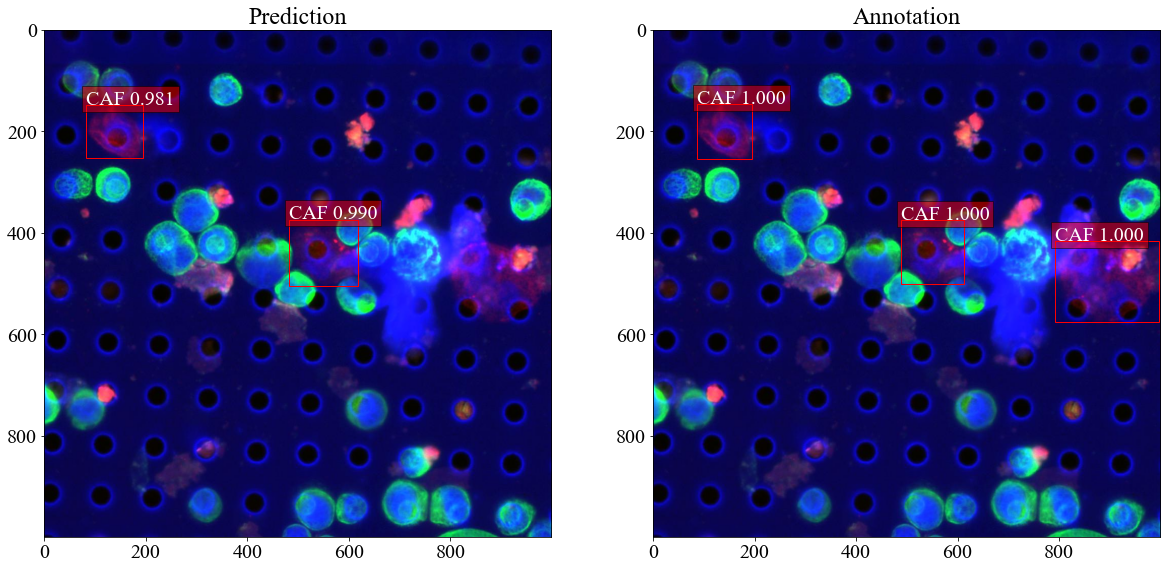

In [ ]:
# visualize the prediction and annotation side by side -> thresh = 0.05
image_id = 26
file_name = df_anno[df_anno['image_id']==image_id]['file_name'].tolist()[0]
print(file_name)
x, image = gcv.data.transforms.presets.ssd.load_test(file_name, 1000)

pred_bboxes = np.asarray(list(df_pred.loc[df_pred.image_id==image_id]['bbox']))
pred_scores = np.asarray(list(df_pred.loc[df_pred.image_id==image_id]['score']))
pred_cids = np.asarray(list(df_pred.loc[df_pred.image_id==image_id]['category_id']))

anno_bboxes = np.asarray(list(df_anno.loc[df_anno.image_id==image_id]['bbox']))
anno_cids = np.asarray(list(df_anno.loc[df_anno.image_id==image_id]['category_id']))
anno_scores = np.ones(anno_cids.shape)

# thresh (float, optional, default 0.5) – Display threshold if scores is provided.
# Scores with less than thresh will be ignored in display, this is visually more elegant
# if you have a large number of bounding boxes with very small scores.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1 = viz.plot_bbox(image, pred_bboxes, pred_scores, pred_cids, thresh=0.98, class_names=['CAF'], ax=ax1, linewidth=1, fontsize=20)
ax1.set_title('Prediction')

ax2 = viz.plot_bbox(image, anno_bboxes, anno_scores, anno_cids, thresh=0.05, class_names=['CAF'], ax=ax2, linewidth=1, fontsize=20)
ax2.set_title('Annotation')
plt.show()

In [ ]:
# select detections with score higher than threshold
score_thre = 0.98
# score_thre = 0.9 # v2
df_pred_slt = df_pred[df_pred['score']>score_thre].reset_index(drop=True)

print(df_pred_slt)
df_pred_slt.head()

     image_id  category_id                                               bbox  \
0           1            0  [0.0, 770.327392578125, 52.335208892822266, 85...   
1           1            0  [480.72900390625, 576.9835815429688, 583.32226...   
2           2            0  [47.43503952026367, 400.9757995605469, 178.359...   
3           3            0  [129.56358337402344, 430.3394775390625, 268.72...   
4           3            0  [103.59695434570312, 843.8298950195312, 216.85...   
..        ...          ...                                                ...   
185        98            0  [636.99365234375, 588.554443359375, 806.981811...   
186        98            0  [462.17529296875, 2.73592472076416, 590.501953...   
187        99            0  [803.552490234375, 154.63644409179688, 956.899...   
188        99            0  [253.0399932861328, 842.2421875, 399.523651123...   
189        99            0  [693.1495361328125, 707.2448120117188, 807.906...   

        score  
0    0.9823

,image_id,category_id,bbox,score
0,1,0,"[0.0, 770.327392578125, 52.335208892822266, 85...",0.982348
1,1,0,"[480.72900390625, 576.9835815429688, 583.32226...",0.980415
2,2,0,"[47.43503952026367, 400.9757995605469, 178.359...",0.989419
3,3,0,"[129.56358337402344, 430.3394775390625, 268.72...",0.994949
4,3,0,"[103.59695434570312, 843.8298950195312, 216.85...",0.992701


In [ ]:
# clean detections by removing overlapping bounding boxes
clean_iou_thre = 0.2
pred_image_ids = np.unique(df_pred_slt['image_id'].to_numpy())
df_pred_slt_clean = []
count = 0
for image_id in pred_image_ids:
  df_pred_image_id = df_pred_slt.loc[df_pred_slt.image_id==image_id].reset_index(drop=True)
  pred_bboxes = list(df_pred_image_id['bbox'])
  remove_idx = remove_overlap_idx(pred_bboxes, clean_iou_thre)
  df_pred_image_id_clean = df_pred_image_id.drop(remove_idx)
  if count == 0:
    df_pred_slt_clean = df_pred_image_id_clean
  else:
    df_pred_slt_clean = pd.concat([df_pred_slt_clean, df_pred_image_id_clean], axis=0)
  count = count+1

print(df_pred_slt_clean)
df_pred_slt_clean.head()

    image_id  category_id                                               bbox  \
0          1            0  [0.0, 770.327392578125, 52.335208892822266, 85...   
1          1            0  [480.72900390625, 576.9835815429688, 583.32226...   
0          2            0  [47.43503952026367, 400.9757995605469, 178.359...   
0          3            0  [129.56358337402344, 430.3394775390625, 268.72...   
1          3            0  [103.59695434570312, 843.8298950195312, 216.85...   
..       ...          ...                                                ...   
1         98            0  [636.99365234375, 588.554443359375, 806.981811...   
2         98            0  [462.17529296875, 2.73592472076416, 590.501953...   
0         99            0  [803.552490234375, 154.63644409179688, 956.899...   
1         99            0  [253.0399932861328, 842.2421875, 399.523651123...   
2         99            0  [693.1495361328125, 707.2448120117188, 807.906...   

       score  
0   0.982348  
1   0.980

,image_id,category_id,bbox,score
0,1,0,"[0.0, 770.327392578125, 52.335208892822266, 85...",0.982348
1,1,0,"[480.72900390625, 576.9835815429688, 583.32226...",0.980415
0,2,0,"[47.43503952026367, 400.9757995605469, 178.359...",0.989419
0,3,0,"[129.56358337402344, 430.3394775390625, 268.72...",0.994949
1,3,0,"[103.59695434570312, 843.8298950195312, 216.85...",0.992701


/content/gdrive/My Drive/Dataset/VOC_ModelSmp_CAF_only_by_slide_MATLAB_CAF_BB_anno_clean_v1/VOC2018/JPEGImages/Model_system-Slide2-Mixture-1225-2021_r1c1x10y3.jpg


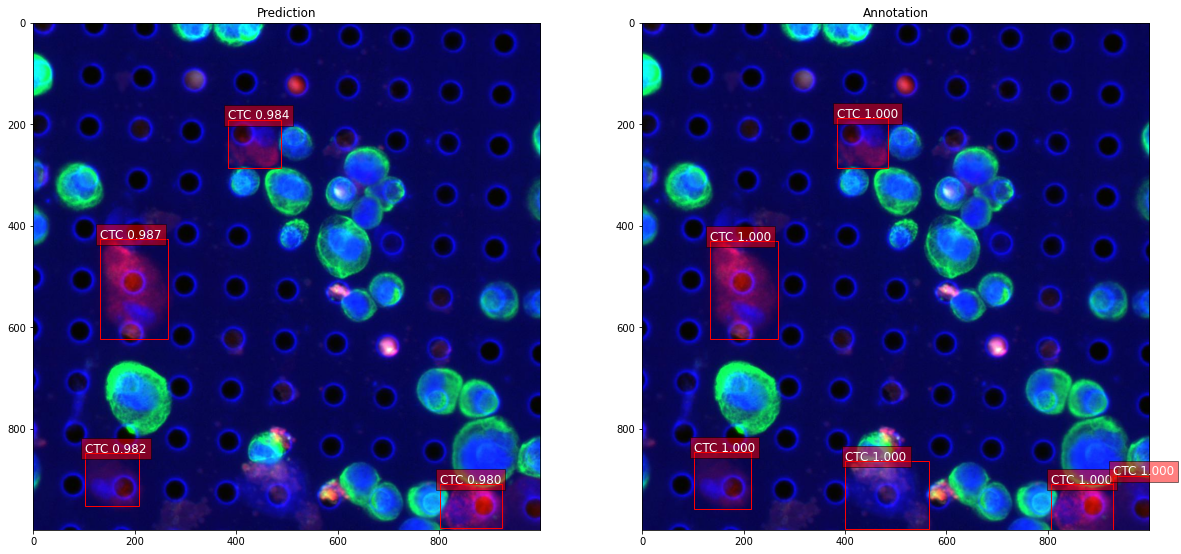

In [ ]:
# visualize the prediction and annotation side by side -> thresh = 0.4
image_id = 3
file_name = df_anno[df_anno['image_id']==image_id]['file_name'].tolist()[0]
print(file_name)
x, image = gcv.data.transforms.presets.ssd.load_test(file_name, 1000)

pred_bboxes = np.asarray(list(df_pred_slt_clean.loc[df_pred_slt_clean.image_id==image_id]['bbox']))
pred_scores = np.asarray(list(df_pred_slt_clean.loc[df_pred_slt_clean.image_id==image_id]['score']))
pred_cids = np.asarray(list(df_pred_slt_clean.loc[df_pred_slt_clean.image_id==image_id]['category_id']))

anno_bboxes = np.asarray(list(df_anno.loc[df_anno.image_id==image_id]['bbox']))
anno_cids = np.asarray(list(df_anno.loc[df_anno.image_id==image_id]['category_id']))
anno_scores = np.ones(anno_cids.shape)

# thresh (float, optional, default 0.5) – Display threshold if scores is provided.
# Scores with less than thresh will be ignored in display, this is visually more elegant
# if you have a large number of bounding boxes with very small scores.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1 = viz.plot_bbox(image, pred_bboxes, pred_scores, pred_cids, thresh=score_thre, class_names=['CTC'], ax=ax1, linewidth=1, fontsize=12)
ax1.set_title('Prediction')

ax2 = viz.plot_bbox(image, anno_bboxes, anno_scores, anno_cids, thresh=score_thre, class_names=['CTC'], ax=ax2, linewidth=1, fontsize=12)
ax2.set_title('Annotation')
plt.show()

In [ ]:
iou_thre = 0.5 # threshold for evaluation IoU

# precision
numerator1 = 0
denominator1 = 0
# recall
numerator2 = 0
denominator2 = 0

test_image_ids = np.unique(df_anno['image_id'].to_numpy())
test_matrix_list = []
for image_id in test_image_ids:
  if image_id in np.unique(df_pred_slt_clean['image_id'].to_numpy()): # at least one predicted box for this test image
    pred_bboxes = list(df_pred_slt_clean.loc[df_pred_slt_clean.image_id==image_id]['bbox'])
    pred_scores = list(df_pred_slt_clean.loc[df_pred_slt_clean.image_id==image_id]['score'])
    anno_bboxes = list(df_anno.loc[df_anno.image_id==image_id]['bbox'])
    if np.sum(np.isnan(np.array(anno_bboxes))): # no annotated box for this test image
      denominator1 = denominator1+len(pred_scores)
    else: # at least one annotated box for this test image
      iou_matrix = np.zeros([len(pred_bboxes),len(anno_bboxes)])
      for pred_idx, pred_bbox in enumerate(pred_bboxes):
        for anno_idx, anno_bbox in enumerate(anno_bboxes):
          iou_matrix[pred_idx, anno_idx] = get_iou(pred_bbox, anno_bbox)
      # # only keep the first successful prediction for each column of annotated object
      # # WRONG! -> cannot rule out the possibility that a prediction box successfully predicts two annotation boxes
      # success_matrix = iou_matrix > iou_thre
      # success_matrix_clean = success_matrix.cumsum(axis=0).cumsum(axis=0) == 1
      success_matrix = []
      for k in range(iou_matrix.shape[0]): # scan through prediction boxes by row
        pred_row = iou_matrix[k,:] > iou_thre
        if np.sum(pred_row)>1: # make sure a prediction box will not be used twice
          pred_row = iou_matrix[k,:] == np.max(iou_matrix[k,:])
        if k==0:
          success_matrix = pred_row
        else:
          success_matrix = np.vstack((success_matrix,pred_row))
      success_matrix_clean = success_matrix.cumsum(axis=0).cumsum(axis=0) == 1
      if len(success_matrix_clean.shape)==1:
        success_matrix_clean = np.array([success_matrix_clean])
      test_matrix_list.append(success_matrix_clean)
  else: # no predicted box for this test image
    anno_bboxes = list(df_anno.loc[df_anno.image_id==image_id]['bbox'])
    if not np.sum(np.isnan(np.array(anno_bboxes))): # at least one annotated box for this test image
      denominator2 = denominator2+len(anno_bboxes)

for success_matrix_clean in test_matrix_list:
  numerator1 = numerator1+np.sum(success_matrix_clean)
  numerator2 = numerator2+np.sum(success_matrix_clean)
  denominator1 = denominator1+success_matrix_clean.shape[0]
  denominator2 = denominator2+success_matrix_clean.shape[1]

precision = numerator1/denominator1
recall = numerator2/denominator2

print('%d out of %d predicted CTCs are true CTCs.' % (numerator1, denominator1))
print('%d out of %d annotated CTCs are detected.' % (numerator2, denominator2))
print('Correct detection: %d; Missed detection: %d; Wrong detection: %d.' % (numerator1, denominator2-numerator2, denominator1-numerator1))
print('Precision = %.1f%%, Recall = %.1f%%' % (precision*100, recall*100))

167 out of 190 predicted CTCs are true CTCs.
167 out of 266 annotated CTCs are detected.
Correct detection: 167; Missed detection: 99; Wrong detection: 23.
Precision = 87.9%, Recall = 62.8%


##### Failure analysis

In [ ]:
# get missed detection and wrong detection
df_anno_miss = []
df_pred_wrong = []
count1 = 0
count2 = 0
test_image_ids = np.unique(df_anno['image_id'].to_numpy())
for image_id in test_image_ids:
  if image_id in np.unique(df_pred_slt_clean['image_id'].to_numpy()): # at least one predicted box for this test image
    df_pred_img = df_pred_slt_clean.loc[df_pred_slt_clean.image_id==image_id].reset_index(drop=True)
    pred_bboxes = list(df_pred_img['bbox'])
    pred_scores = list(df_pred_img['score'])
    
    df_anno_img = df_anno.loc[df_anno.image_id==image_id].reset_index(drop=True)
    anno_bboxes = list(df_anno_img['bbox'])
    
    if np.sum(np.isnan(np.array(anno_bboxes))): # no annotated box for this test image
      df_pred_img_wrong = df_pred_img
      if count2 == 0:
        df_pred_wrong = df_pred_img_wrong
        count2 = count2+1
      else:
        df_pred_wrong = pd.concat([df_pred_wrong, df_pred_img_wrong], axis=0)
    else: # at least one annotated box for this test image
      iou_matrix = np.zeros([len(pred_bboxes), len(anno_bboxes)])
      for pred_idx, pred_bbox in enumerate(pred_bboxes):
        for anno_idx, anno_bbox in enumerate(anno_bboxes):
          iou_matrix[pred_idx, anno_idx] = get_iou(pred_bbox, anno_bbox)
      success_matrix = []
      for k in range(iou_matrix.shape[0]): # scan through prediction boxes by row
        pred_row = iou_matrix[k,:] > iou_thre
        if np.sum(pred_row)>1: # make sure a prediction box will not be used twice
          pred_row = iou_matrix[k,:] == np.max(iou_matrix[k,:])
        if k==0:
          success_matrix = pred_row
        else:
          success_matrix = np.vstack((success_matrix,pred_row))
      success_matrix_clean = success_matrix.cumsum(axis=0).cumsum(axis=0) == 1
      if len(success_matrix_clean.shape) == 1:
        success_matrix_clean = np.array([success_matrix_clean])
      
      remove_idx1 = np.where(np.sum(success_matrix_clean,axis=0)==1)[0]
      df_anno_img_miss = df_anno_img.drop(remove_idx1)
      if count1 == 0:
        df_anno_miss = df_anno_img_miss
        count1 = count1+1
      else:
        df_anno_miss = pd.concat([df_anno_miss, df_anno_img_miss], axis=0)
      
      remove_idx2 = np.where(np.sum(success_matrix_clean,axis=1)==1)[0]
      df_pred_img_wrong = df_pred_img.drop(remove_idx2)      
      if count2 == 0:
        df_pred_wrong = df_pred_img_wrong
        count2 = count2+1
      else:
        df_pred_wrong = pd.concat([df_pred_wrong, df_pred_img_wrong], axis=0)

  else: # no predicted box for this test image
    df_anno_img = df_anno.loc[df_anno.image_id==image_id].reset_index(drop=True)
    anno_bboxes = list(df_anno_img['bbox'])
    if not np.sum(np.isnan(np.array(anno_bboxes))): # at least one annotated box for this test image
      df_anno_img_miss = df_anno_img
      if count1 == 0:
        df_anno_miss = df_anno_img_miss
        count1 = count1+1
      else:
        df_anno_miss = pd.concat([df_anno_miss, df_anno_img_miss], axis=0)

print(len(df_anno_miss),len(df_pred_wrong))

99 23


In [ ]:
# output missed detection
anno_miss_saving_path = os.path.join(saving_path,'test_prediciton_scoreTH'+str(score_thre)+'cleanIoUTH'+str(clean_iou_thre)+'_anno_miss')
os.makedirs(anno_miss_saving_path, exist_ok=True)

image_ids = np.unique(df_anno_miss['image_id'].to_numpy())
for image_id in image_ids:
  file_name = df_anno_miss[df_anno_miss['image_id']==image_id]['file_name'].tolist()[0]
  x, image = gcv.data.transforms.presets.ssd.load_test(file_name, 1000)

  pred_bboxes = np.asarray(list(df_pred_slt_clean.loc[df_pred_slt_clean.image_id==image_id]['bbox']))
  pred_scores = np.asarray(list(df_pred_slt_clean.loc[df_pred_slt_clean.image_id==image_id]['score']))
  pred_cids = np.asarray(list(df_pred_slt_clean.loc[df_pred_slt_clean.image_id==image_id]['category_id']))

  anno_bboxes = np.asarray(list(df_anno_miss.loc[df_anno_miss.image_id==image_id]['bbox']))
  anno_cids = np.asarray(list(df_anno_miss.loc[df_anno_miss.image_id==image_id]['category_id']))
  anno_scores = np.ones(anno_cids.shape)

  # thresh (float, optional, default 0.5) – Display threshold if scores is provided.
  # Scores with less than thresh will be ignored in display, this is visually more elegant
  # if you have a large number of bounding boxes with very small scores.
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
  ax1 = viz.plot_bbox(image, pred_bboxes, pred_scores, pred_cids, thresh=score_thre, class_names=['CTC'], ax=ax1, linewidth=1, fontsize=8)
  ax1.set_title('Prediction')

  if np.sum(np.isnan(anno_bboxes)):
    ax2.imshow(image)
    ax2.set_title('Missed annotation')
  else:
    ax2 = viz.plot_bbox(image, anno_bboxes, anno_scores, anno_cids, thresh=score_thre, class_names=['CTC'], ax=ax2, linewidth=1, fontsize=8)
    ax2.set_title('Missed annotation')
  fig.savefig(os.path.join(anno_miss_saving_path,os.path.splitext(os.path.basename(file_name))[0]+'.png'))

In [ ]:
# output wrong detection
pred_wrong_saving_path = os.path.join(saving_path,'test_prediciton_scoreTH'+str(score_thre)+'cleanIoUTH'+str(clean_iou_thre)+'_pred_wrong')
os.makedirs(pred_wrong_saving_path, exist_ok=True)

image_ids = np.unique(df_pred_wrong['image_id'].to_numpy())
for image_id in image_ids:
  file_name = df_anno[df_anno['image_id']==image_id]['file_name'].tolist()[0]
  x, image = gcv.data.transforms.presets.ssd.load_test(file_name, 1000)

  pred_bboxes = np.asarray(list(df_pred_wrong.loc[df_pred_wrong.image_id==image_id]['bbox']))
  pred_scores = np.asarray(list(df_pred_wrong.loc[df_pred_wrong.image_id==image_id]['score']))
  pred_cids = np.asarray(list(df_pred_wrong.loc[df_pred_wrong.image_id==image_id]['category_id']))

  anno_bboxes = np.asarray(list(df_anno.loc[df_anno.image_id==image_id]['bbox']))
  anno_cids = np.asarray(list(df_anno.loc[df_anno.image_id==image_id]['category_id']))
  anno_scores = np.ones(anno_cids.shape)

  # thresh (float, optional, default 0.5) – Display threshold if scores is provided.
  # Scores with less than thresh will be ignored in display, this is visually more elegant
  # if you have a large number of bounding boxes with very small scores.
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
  ax1 = viz.plot_bbox(image, pred_bboxes, pred_scores, pred_cids, thresh=score_thre, class_names=['CTC'], ax=ax1, linewidth=1, fontsize=8)
  ax1.set_title('Wrong prediction')

  if np.sum(np.isnan(anno_bboxes)):
    ax2.imshow(image)
    ax2.set_title('Annotation')
  else:
    ax2 = viz.plot_bbox(image, anno_bboxes, anno_scores, anno_cids, thresh=score_thre, class_names=['CTC'], ax=ax2, linewidth=1, fontsize=8)
    ax2.set_title('Annotation')
  fig.savefig(os.path.join(pred_wrong_saving_path,os.path.splitext(os.path.basename(file_name))[0]+'.png'))